In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#! git clone https://github.com/MichaelGerhard/PlantDiseaseData
! git clone https://github.com/spMohanty/PlantVillage-Dataset


Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 41.08 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (182401/182401), done.


In [3]:
#importing necessary libraries and APIs

import warnings
warnings.filterwarnings("ignore")
import os
import glob
import matplotlib.pyplot as plt
import keras

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [5]:
#data path

data_dir = "/content/PlantVillage-Dataset/raw/segmented"


In [6]:
#function that counts the number of files in a dierctory
def get_files(dir):
  if not os.path.exists(dir):
    return 0
  c=0 #initialize count with zero
  for curr_path,dirs,files in os.walk(dir):
    for d in dirs:
      c+= len(glob.glob(os.path.join(curr_path,d+"/*")))

  return c

In [7]:
segmented_data=get_files(data_dir)
num_classes=len(glob.glob(data_dir+"/*"))
print(num_classes,"Classes")


38 Classes


In [8]:
pip install split-folders


In [9]:
import splitfolders 
splitfolders.ratio("/content/PlantVillage-Dataset/raw/segmented", output="train_test", seed=1337, ratio=(.8, .2), group_prefix=None) # default values


Copying files: 54306 files [00:08, 6742.29 files/s]


In [10]:
train_dir ="/content/train_test/train"
test_dir="/content/train_test/val"


In [11]:
#data generator to generate images 

train_datagen=ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, validation_split=0.2, horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [12]:
img_width,img_height =224,224 #sizes are compatible with MobileNet
input_shape=(img_width,img_height,3)
batch_size =64
train_generator =train_datagen.flow_from_directory(train_dir,shuffle=True, #added shuffle here
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size,
                                                   subset='training'
                                                   )
validation_generator =train_datagen.flow_from_directory(train_dir,shuffle=True, #added shuffle here
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size,
                                                   subset='validation')

test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)

Found 34757 images belonging to 38 classes.
Found 8673 images belonging to 38 classes.
Found 10876 images belonging to 38 classes.


In [13]:
print(len(validation_generator))

136


In [15]:

for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape



((64, 224, 224, 3), (64, 38))

In [16]:
print (train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
  f.write(labels)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [17]:

IMG_SHAPE = (img_width, img_height, 3)

# base model is the pre-trained model MobileNet V2 (from keras library)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.trainable=False

9412608/9406464 [==============================] - 0s 0us/step


In [19]:
#Adding the layers (model 1)
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='elu'),
  tf.keras.layers.Dropout(0.5),  #increase dropout
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(38, activation='softmax')
])

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [21]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 38)                1254      
Total params: 2,627,910
Trainable params: 369,926
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))


Number of trainable variables = 4


In [ ]:
epochs = 10

history = model.fit(train_generator, 
                    epochs=epochs, 
                    validation_data=validation_generator)

In [26]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

170/170 [==============================] - 22s 130ms/step - loss: 0.2236 - accuracy: 0.9282
Test loss: 0.2236027717590332
Test accuracy: 0.9281905293464661


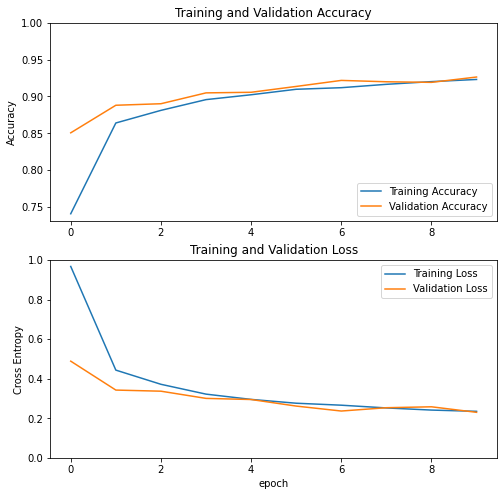

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()